Reprojecting SunPy maps from one reference frame to another is most commonly done with [full-disk images](https://docs.sunpy.org/en/stable/generated/gallery/map_transformations/reprojection_different_observers.html#sphx-glr-generated-gallery-map-transformations-reprojection-different-observers-py). The built-in implementation of _reproject_to()_ is also capable of reprojecting submaps or cutouts; however, unless the output WCS are carefully adjusted this is just as slow as reprojecting a full-disk image.

To adjust the output WCS to match the size of the reprojected cutout - and therefore to execute _reproject_ without a potentially 4k x 4k array - the CRPIX keywords must be adjusted to account for the new origin in the desired output matrix shape.

This example uses images from November 2021, when Solar Orbiter was close to the Earth and their fields-of-view were quite similar.

In [10]:
import pandas as pd
import sunpy.map
from stix_utils import load_SOLO_SPICE
from visible_from_earth import get_observer
from flare_physics_utils import cartesian_diff
from astropy.coordinates import SkyCoord
from astropy import units as u

In [3]:
%matplotlib notebook

In [2]:
peak_utc_corrected=pd.to_datetime('2021-11-02 07:45:11')
load_SOLO_SPICE(peak_utc_corrected)
sobs,swcs=get_observer(peak_utc_corrected,obs='SOLO')



SPICE kernels loaded correctly



<IPython.core.display.Javascript object>


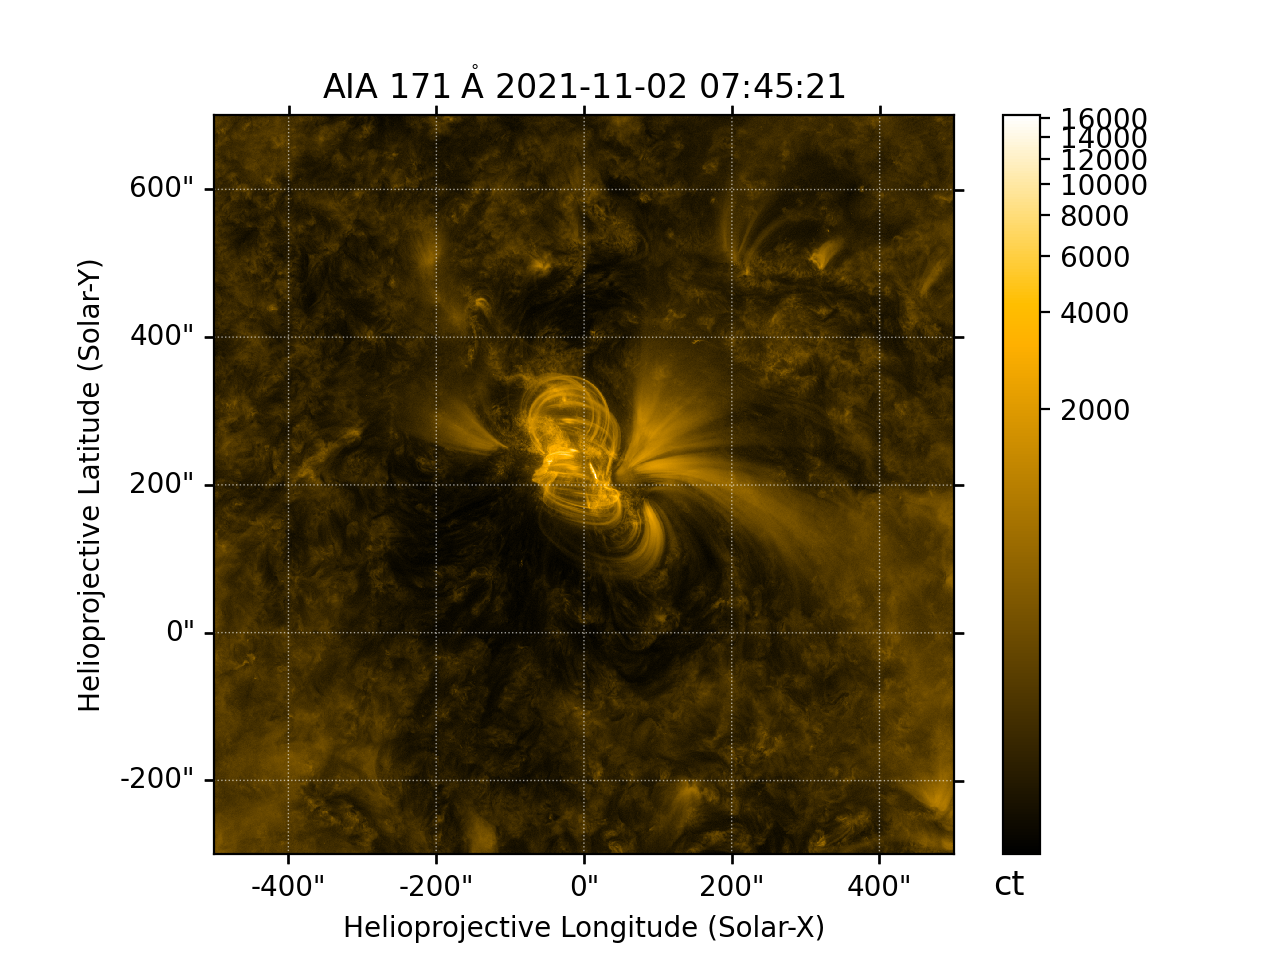

In [6]:
mcutout=sunpy.map.Map('aia.lev1_euv_12s.2021-11-02T074511Z.171.image._prepped.fits')
mcutout.peek()

To get the Solar Orbiter WCS, it is necessary to first load the proper SPICE kernels.

One can then reproject the AIA map to the Solar Orbiter viewpoint using the built-in _reproject_to():

In [7]:
%%time
mr=mcutout.reproject_to(swcs)

CPU times: user 29 s, sys: 10.5 s, total: 39.5 s
Wall time: 41 s


However, this is very slow! This is because the default size of the Solar Orbiter WCS array matches the full-disk AIA size of (4096,4096). A lot of time is wasted reprojecting NaNs.

To adjust the Solar Orbiter WCS, new CRPIX and CDELT WCS keywords must be calculated. CDELT can be calculated automatically as will be shown, but some adjustments must be made to CRPIX. For this, three quantities are needed: A reference coordinate for the  Solar Orbiter coordinate frame, the new size of the reprojected data array, and the pixel scale factor.

A reference coordinate is constructed by:


In [11]:
refcoord=SkyCoord(0,0,unit=u.arcsec,frame='helioprojective',observer=sobs,obstime=sobs.obstime)
stix_ref_coord=mcutout.reference_coordinate.transform_to(refcoord.frame)

Here, _refcoord_ is the coordinate (0",0") in the Solar Orbiter frame, and _stix_ref_coord_ is the coordinate (0",0") in the AIA coordinate frame transformed to the Solar Orbiter frame
(_make_fitswcs_header()_ gives the same result whether using _refcoord_ or _stix_ref_coord_, but the difference between the two will be important later). In this example, _stix_ref_coord_ is (27.8",43.5").

Next, find the extent of the new data array after reprojection (without doing the reprojection of course)!

In [13]:
blr=mcutout.bottom_left_coord.transform_to(refcoord.frame)
trr=mcutout.top_right_coord.transform_to(refcoord.frame)
width, height=cartesian_diff(blr,trr) #arcsec

Finally scale the pixel size to account for distance of the spacecraft from the Sun and use that to get the final array shape:

In [14]:
scale=(1., 1.)*(sobs.radius.to(u.AU).value*u.arcsec/u.pixel) 
out_shape=(int((height/scale[1]).value),int((width/scale[0]).value))

_height_ and _width_ are swapped from their usual indices to account for Sunpy maps indexing at 1.

Make a new FITS header/WCS object for input to _reproject_:

In [16]:
submap_header=sunpy.map.make_fitswcs_header(out_shape,refcoord,scale=scale,
instrument="STIX",observatory="Solar Orbiter") 

This will NOT account for the difference between (0",0") in the Solar Orbiter frame and the AIA frame! That needs to be calculated by hand:

In [17]:
def new_crpix(mcutout,stix_ref_coord,scale):
    mcrpix=mcutout.wcs.wcs.crpix
    stix_aia_offset=(stix_ref_coord.Tx.value, stix_ref_coord.Ty.value)/scale.value
    return (mcrpix-stix_aia_offset)*scale.value

In [18]:
scrpix=new_crpix(mcutout,stix_ref_coord,scale)

Update the CRPIX keywords in the header dictionary, and then do the reprojection:

In [20]:
submap_header['crpix1']=scrpix[0]
submap_header['crpix2']=scrpix[1]
rotated_map = mcutout.reproject_to(submap_header)

<IPython.core.display.Javascript object>


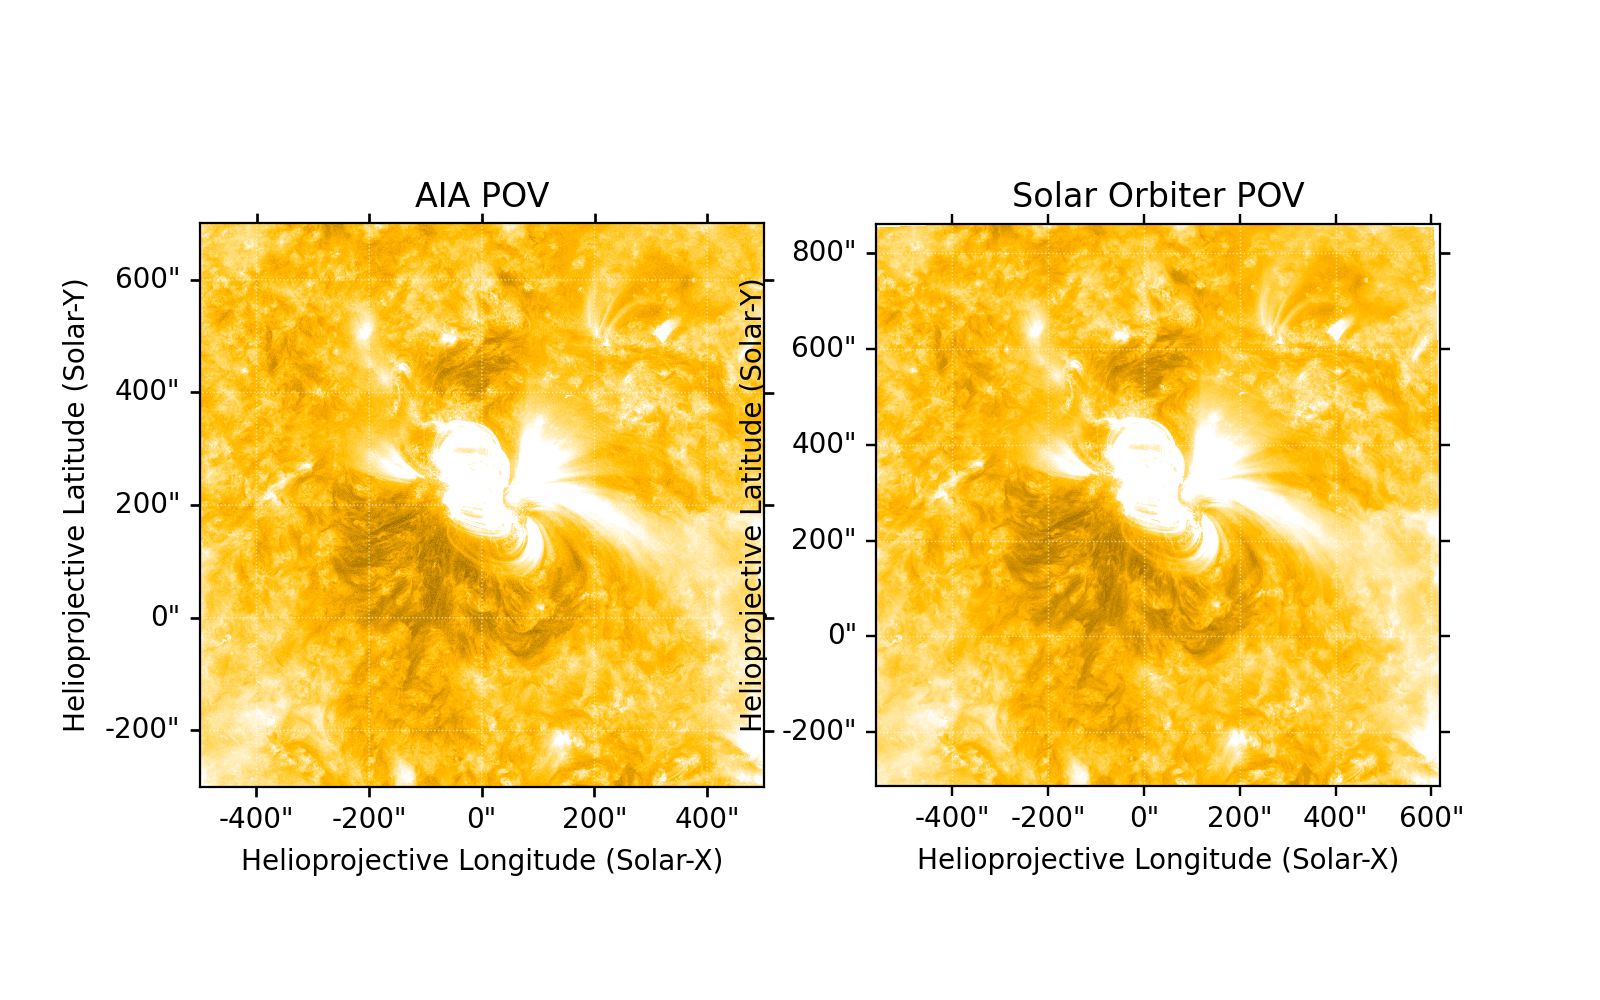

Text(0.5, 1.0, 'Solar Orbiter POV')

In [21]:
fig=plt.figure(figsize=(8,5))
ax0=fig.add_subplot(1,2,1,projection=mcutout)
mcutout.plot(axes=ax0,vmin=0,vmax=500)
ax0.set_title('AIA POV')
ax1=fig.add_subplot(1,2,2,projection=rotated_map)
rotated_map.plot(axes=ax1,vmin=0,vmax=500,cmap='sdoaia171')
ax1.set_title('Solar Orbiter POV')

This results in a speed-up of 8-9x for this 1000" x 1000" cutout.

In [24]:
def smart_reproject(mcutout,sobs,instrument='STIX',observatory='Solar Orbiter'):
    refcoord=SkyCoord(0,0,unit=u.arcsec,frame='helioprojective',observer=sobs,obstime=sobs.obstime)
    stix_ref_coord=mcutout.reference_coordinate.transform_to(refcoord.frame)
    blr=mcutout.bottom_left_coord.transform_to(refcoord.frame)
    trr=mcutout.top_right_coord.transform_to(refcoord.frame)
    width, height=cartesian_diff(blr,trr) #arcsec
    scale=(1., 1.)*(sobs.radius.to(u.AU).value*u.arcsec/u.pixel)
    out_shape=(int((height/scale[1]).value),int((width/scale[0]).value)) #pixel extent, index at 1
    submap_header=sunpy.map.make_fitswcs_header(out_shape, refcoord,
                                      scale=scale,
                                      instrument=instrument,observatory=observatory)
    scrpix=new_crpix(mcutout,stix_ref_coord,scale)
    submap_header['crpix1']=scrpix[0]
    submap_header['crpix2']=scrpix[1]
    #output, _ = reproject_interp(mcutout, Header(submap_header))
    #rotated_map = Map((output, submap_header))
    rotated_map=mcutout.reproject_to(submap_header)
    return rotated_map

In [25]:
%%timeit
rotated_map=smart_reproject(mcutout,sobs)


4.08 s ± 85.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
